# Bank Marketing: Predicting Customer Decision 




In [151]:
import warnings
warnings.filterwarnings("ignore")#action='once') #warning appears only one
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
from sklearn.linear_model import Lasso,Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

In [152]:
bktrain=pd.read_csv("C:/Users/CRL/Box Sync/PythonProjects/Marketing/bank-additional.csv",sep=";")
bktest=pd.read_csv("C:/Users/CRL/Box Sync/PythonProjects/Marketing/bank-additional-full.csv",sep=";")

In [153]:
bktest1=bktest.sample(frac=0.1,random_state=12)
bktest2=bktest.sample(frac=0.1,random_state=456)

In [154]:
bktest1.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
28800,45,entrepreneur,married,university.degree,no,yes,no,cellular,apr,thu,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.410,5099.1,no
31345,36,admin.,single,basic.6y,no,yes,no,cellular,may,wed,...,2,999,1,failure,-1.8,92.893,-46.2,1.334,5099.1,no
20075,49,services,married,high.school,no,yes,yes,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
2929,33,admin.,married,high.school,no,yes,yes,telephone,may,wed,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,no
4776,34,blue-collar,married,basic.9y,no,no,no,telephone,may,wed,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no


## Cleaning and Feature Engineering

In [155]:
def new_dat(x):
    '''Function to create a new cleanned data frame for training or for testing the models'''
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import LabelEncoder  
    Couple=[]
    for i in x.index:
        if list(x.marital)[i]=="married":
            Couple.append(1)
        elif list(x.marital)[i]=="single":
            Couple.append(0)
        elif list(x.marital)[i]=="divorced":
            Couple.append(0)
        elif list(x.marital)[i]=="unknown":
            Couple.append(np.nan)

    # Transform y from str to int  (yes=1)      
    lab = LabelEncoder()
    y=lab.fit_transform(x.y)

    # Transform loan from str to int  (yes=1)      
    lab = LabelEncoder()
    Loan=lab.fit_transform(x.loan)       # no=0;unknown=1;yes=2

    # Transform housing from str to int  (yes=1)      
    lab = LabelEncoder()
    Housing=lab.fit_transform(x.housing)       # no=0;unknown=1;yes=2

    # Transform default from str to int  (yes=1)      
    lab = LabelEncoder()
    Default=lab.fit_transform(x.default) # no=0;unknown=1;yes=2

    # last day contact
    days={'mon':1, 'tue':2,'wed':3,'thu':4,'fri':5}
    Day=[]
    for i in x.index:
        Day.append(days[x.day_of_week[i]])

    # last month contact
    months={'may':5, 'jun':6, 'nov':11, 'sep':9, 'jul':7, 'aug':8, 'mar':3, 'oct':10, 'apr':4,
           'dec':12}
    Month=[]
    for i in x.index:
        Month.append(months[x.month[i]])


    # Education
    from sklearn.preprocessing import LabelEncoder  
    Education=[]
    for i in x.index:
        if list(x.education)[i]=='university.degree':
            Education.append(5)
        elif list(x.education)[i]=='professional.course':
            Education.append(4)
        elif list(x.education)[i]=='high.school':
            Education.append(3)
        elif list(x.education)[i]=='illiterate':
            Education.append(0)
        elif list(x.education)[i]=='basic.9y':
            Education.append(2)
        elif list(x.education)[i]=='unknown':
            Education.append(np.nan)
        else:
            Education.append(1)

    Job=[]
    for i in x.index:
        if list(x.job)[i]=='unemployed':
            Job.append(0)
        elif (list(x.job)[i]=='retired') or (list(x.job)[i]=='student'):
            Job.append(1)
        elif (list(x.job)[i]=='blue-collar') or (list(x.job)[i]=='technician') or(list(x.job)[i]=='housemaid'):
            Job.append(2)
        elif (list(x.job)[i]=='admin.') or (list(x.job)[i]=='management') or (list(x.job)[i]=='entrepreneur') or (list(x.job)[i]=='self-employed') or (list(x.job)[i]=='services'):
            Job.append(4)
        elif list(x.job)[i]=='unknown':
            Job.append(np.nan)

    # Replace 999 by NaN in pdays
    Pdays=[] # number of days that passed by after the client was last contacted from a previous campaign
    for i in x.index:
        if list(x.pdays)[i]==999:
            Pdays.append(np.nan)
        else:
            Pdays.append(x.pdays[i])
    df=pd.DataFrame({"Age":x.age,"Couple":Couple,"Education":Education,"Job":Job,"Loan":Loan,"Housing":Housing,"Default":Default, "Campaign":x.campaign,"Day":Day,"Month":Month,
                     'EmployementRate':x['emp.var.rate'],'IPC':x['cons.price.idx'],'Confidence':x['cons.conf.idx'],'Euribor':x['euribor3m'],"Deposit":y})
    return df

In [156]:
train=new_dat(bktrain);train.head()

,Age,Couple,Education,Job,Loan,Housing,Default,Campaign,Day,Month,EmployementRate,IPC,Confidence,Euribor,Deposit
0,30,1.0,2.0,2.0,0,2,0,2,5,5,-1.8,92.893,-46.2,1.313,0
1,39,0.0,3.0,4.0,0,0,0,4,5,5,1.1,93.994,-36.4,4.855,0
2,25,1.0,3.0,4.0,0,2,0,1,3,6,1.4,94.465,-41.8,4.962,0
3,38,1.0,2.0,4.0,1,1,0,3,5,6,1.4,94.465,-41.8,4.959,0
4,47,1.0,5.0,4.0,0,2,0,1,1,11,-0.1,93.200,-42.0,4.191,0


In [157]:
def new_dattest(x):
    '''Function to create a new cleanned data frame for training or for testing the models'''
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import LabelEncoder  
   
    Couple=[]
    for i in range(len(x.index)):
        if list(x.marital)[i]=="married":
            Couple.append(1)
        elif list(x.marital)[i]=="single":
            Couple.append(0)
        elif list(x.marital)[i]=="divorced":
            Couple.append(0)
        elif list(x.marital)[i]=="unknown":
            Couple.append(np.nan)
    
    # Transform y from str to int  (yes=1)      
    lab = LabelEncoder()
    y=lab.fit_transform(x.y)
    
    # Transform loan from str to int  (yes=1)      
    lab = LabelEncoder()
    Loan=lab.fit_transform(x.loan)       # no=0;unknown=1;yes=2

    # Transform housing from str to int  (yes=1)      
    lab = LabelEncoder()
    Housing=lab.fit_transform(x.housing)       # no=0;unknown=1;yes=2

    # Transform default from str to int  (yes=1)      
    lab = LabelEncoder()
    Default=lab.fit_transform(x.default) # no=0;unknown=1;yes=2

    # last day contact
    days={'mon':1, 'tue':2,'wed':3,'thu':4,'fri':5}
    Day=[]
    for i in x.index:
        Day.append(days[x.day_of_week[i]])

    # last month contact
    months={'may':5, 'jun':6, 'nov':11, 'sep':9, 'jul':7, 'aug':8, 'mar':3, 'oct':10, 'apr':4,
           'dec':12}
    Month=[]
    for i in x.index:
        Month.append(months[x.month[i]])


    # Education
    from sklearn.preprocessing import LabelEncoder  
    Education=[]
    for i in range(len(x.index)):
        if list(x.education)[i]=='university.degree':
            Education.append(5)
        elif list(x.education)[i]=='professional.course':
            Education.append(4)
        elif list(x.education)[i]=='high.school':
            Education.append(3)
        elif list(x.education)[i]=='illiterate':
            Education.append(0)
        elif list(x.education)[i]=='basic.9y':
            Education.append(2)
        elif list(x.education)[i]=='unknown':
            Education.append(np.nan)
        else:
            Education.append(1)

    Job=[]
    for i in range(len(x.index)):
        if list(x.job)[i]=='unemployed':
            Job.append(0)
        elif (list(x.job)[i]=='retired') or (list(x.job)[i]=='student'):
            Job.append(1)
        elif (list(x.job)[i]=='blue-collar') or (list(x.job)[i]=='technician') or(list(x.job)[i]=='housemaid'):
            Job.append(2)
        elif (list(x.job)[i]=='admin.') or (list(x.job)[i]=='management') or (list(x.job)[i]=='entrepreneur') or (list(x.job)[i]=='self-employed') or (list(x.job)[i]=='services'):
            Job.append(4)
        elif list(x.job)[i]=='unknown':
            Job.append(np.nan)

    # Replace 999 by NaN in pdays
    Pdays=[] # number of days that passed by after the client was last contacted from a previous campaign
    for i in range(len(x.index)):
        if list(x.pdays)[i]==999:
            Pdays.append(np.nan)
        else:
            Pdays.append(list(x.pdays)[i])
    df=pd.DataFrame({"Age":x.age,"Couple":Couple,"Education":Education,"Job":Job,"Loan":Loan,"Housing":Housing,"Default":Default, "Campaign":x.campaign,"Day":Day,"Month":Month,
                     'EmployementRate':x['emp.var.rate'],'IPC':x['cons.price.idx'],'Confidence':x['cons.conf.idx'],'Euribor':x['euribor3m'],"Deposit":y})
    return df

In [158]:
# Two dataset to test the model selected
test1=new_dattest(bktest1)
test2=new_dattest(bktest2)

In [159]:
test1.head()

,Age,Couple,Education,Job,Loan,Housing,Default,Campaign,Day,Month,EmployementRate,IPC,Confidence,Euribor,Deposit
28800,45,1.0,5.0,4.0,0,2,0,2,4,4,-1.8,93.075,-47.1,1.410,0
31345,36,0.0,1.0,4.0,0,2,0,2,3,5,-1.8,92.893,-46.2,1.334,0
20075,49,1.0,3.0,4.0,2,2,0,1,1,8,1.4,93.444,-36.1,4.965,0
2929,33,1.0,3.0,4.0,2,2,0,2,3,5,1.1,93.994,-36.4,4.859,0
4776,34,1.0,2.0,2.0,0,0,0,2,3,5,1.1,93.994,-36.4,4.858,0


In [160]:
test2.head()

,Age,Couple,Education,Job,Loan,Housing,Default,Campaign,Day,Month,EmployementRate,IPC,Confidence,Euribor,Deposit
37560,25,0.0,3.0,1.0,0,0,0,1,5,8,-2.9,92.201,-31.4,0.869,0
8368,60,1.0,5.0,4.0,0,0,1,7,2,6,1.4,94.465,-41.8,4.864,0
35758,38,1.0,3.0,4.0,1,1,0,3,1,5,-1.8,92.893,-46.2,1.244,0
26379,40,0.0,5.0,4.0,0,0,0,1,4,11,-0.1,93.200,-42.0,4.076,1
32363,38,1.0,4.0,2.0,0,0,0,1,5,5,-1.8,92.893,-46.2,1.313,0


##### Verify the presence of sparse classes in features of training data

In [161]:
def sparse_classes(x,p):
    '''This function verify if there are sparse classes in the features.
    The function allow the user to determine the feature where one or several
    classes proportion is less than p.'''
    y=[]
    for j in x:
        y.append(x.count(j))
    m=np.median(y)
    z=[];v=[]
    for i in x:
        t=x.count(i)
        if (t<m) and (((m-t)/m)<p):
                z.append(i); v.append((m-t)/m)
        df=pd.DataFrame({"Classes":z,"Percent":v})
        if df.shape[0]==0:
            return ("There is not any sparse classe in the feature")
        else:
            return df

In [162]:
cols=['Education','Job','Day',"Month"]
for i in cols:
    print(sparse_classes(list(train[i]),p=0.05),i)


There is not any sparse classe in the feature Education
There is not any sparse classe in the feature Job
There is not any sparse classe in the feature Day
There is not any sparse classe in the feature Month


##### Correlation between the features and the lable
The features EmployementRate, IPC and Euribor are highly carrelated. Two of them will be removed: EmployementRate and Euribor.

<IPython.core.display.Javascript object>


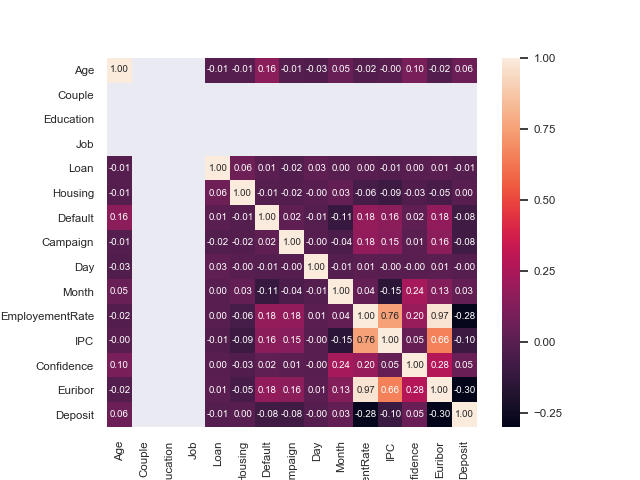

In [163]:
plt.figure()
correl = np.corrcoef(train.values.T)
sns.set(font_scale=0.75)
hm = sns.heatmap(correl, cbar=True,annot=True,square=True,fmt='.2f',
                 annot_kws={'size': 7},yticklabels=train.columns,xticklabels=train.columns)
plt.show()

The correlations are calculated after removing EmployementRate and Euribor among the features. The heatmap bellow shows that there is not any feature highly correlated with another one.

In [164]:
train2=train.loc[:,['Age', 'Couple', 'Education', 'Job', 'Loan', 'Housing', 'Default',
       'Campaign', 'Day', 'Month', 'IPC', 'Confidence','Deposit']]

<IPython.core.display.Javascript object>


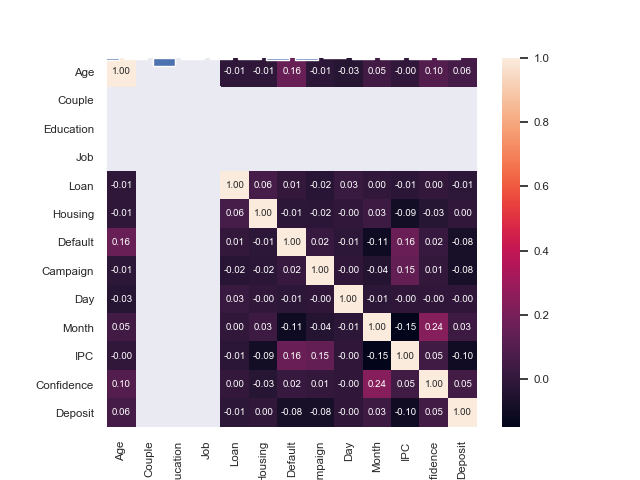

In [165]:
plt.figure()
correl = np.corrcoef(train2.values.T)
sns.set(font_scale=0.75)
hm = sns.heatmap(correl, cbar=True,annot=True,square=True,fmt='.2f',
                 annot_kws={'size': 7},yticklabels=train2.columns,xticklabels=train2.columns)
plt.show()

##### Features scaling

In [166]:
train3=train2.dropna()
X=train3.loc[:,['Age', 'Couple', 'Education', 'Job', 'Loan', 'Housing', 'Default',
       'Campaign', 'Day', 'Month', 'IPC', 'Confidence']]

y=train3["Deposit"]
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)

######## Test 1 ###############
test1=test1.dropna()
X_test1=test1.loc[:,['Age', 'Couple', 'Education', 'Job', 'Loan', 'Housing', 'Default',
       'Campaign', 'Day', 'Month', 'IPC', 'Confidence']]
y_test1=test1.Deposit

######## Test 2 ###############
test2=test2.dropna()
X_test2=test2.loc[:,['Age', 'Couple', 'Education', 'Job', 'Loan', 'Housing', 'Default',
       'Campaign', 'Day', 'Month', 'IPC', 'Confidence']]
y_test2=test2.Deposit

In [167]:
def MyScaler(x):
    '''This function scale with MinMax method only the features '''
    num=["Age","IPC","Confidence"]
    x_num=x[num]
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler().fit(x_num)  #compute minimum and maximum on the training data
    scaled = scaler.transform(x_num) # rescale X
        
    categoric=x[['Couple', 'Education', 'Job', 'Loan', 'Housing', 'Default',
       'Campaign', 'Day', 'Month']]
    df_num=pd.DataFrame(scaled);df_num.columns=num
    categoric.reset_index(inplace=True)
    df=pd.merge(df_num,categoric,left_index=True, right_index=True)
    return df

In [168]:
X_train0=MyScaler(X_train); X_test0=MyScaler(X_test)
X_test1=MyScaler(X_test1); X_test2=MyScaler(X_test2)

## Trainning the model

In [82]:
Scoring='recall_micro'
# 1) Logistic regression
logreg = LogisticRegression()
log_scores = cross_val_score(logreg, X_train0,y_train,cv=4,scoring=Scoring)

# 2) Linear support vector 
svm=LinearSVC(random_state=0,max_iter=100000) # should have random_state not to change estimates
svm_scores = cross_val_score(svm,  X_train0, y_train,cv=4,scoring=Scoring)

# 3) kernalized support vector
svc=SVC(kernel="linear",C=1,gamma=5,max_iter=100000)
svc_scores=cross_val_score(svc,  X_train0, y_train,cv=4,scoring=Scoring)

# 4) kernalized support vector with RBF
svc=SVC(kernel="rbf",C=1,gamma=5,max_iter=100000)
svc_rbf_scores=cross_val_score(svc,  X_train0, y_train,cv=4,scoring=Scoring)

# knn
knn = KNeighborsClassifier(n_neighbors=3)
knn_scores = cross_val_score(knn,  X_train0, y_train,cv=4,scoring=Scoring)

# Neural network (multilayer perceptron)
mpl=MLPClassifier(random_state=0,hidden_layer_sizes=[21])
mpl_scores=cross_val_score(mpl, X_train0, y_train,cv=4,scoring=Scoring)

# Decision tree
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree_scores=cross_val_score(tree, X_train0, y_train,cv=4,scoring=Scoring)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(n_estimators=5, random_state=2)
forest_scores=cross_val_score(forest, X_train0, y_train,cv=4,scoring=Scoring)

# Gradient
from sklearn.ensemble import GradientBoostingClassifier
grad = GradientBoostingClassifier(random_state=0)
grad_scores=cross_val_score(grad, X_train0, y_train,cv=4,scoring=Scoring)

["Logistic: {}".format(round(log_scores.mean(),3)),"SVM: {}".format(round(svm_scores.mean(),3))
                  ,"SVC, with linear kernel :{}".format(round(svc_scores.mean(),3)),"SVC with RBF:{}".format(round(svc_rbf_scores.mean(),3)),
         "MPL: {}".format(round(mpl_scores.mean(),3)),"KNN: {}".format(round(knn_scores.mean(),3)),"Tree: {}".format(round(tree_scores.mean(),3)),
"Forest: {}".format(round(forest_scores.mean(),3)),"Gradient: {}".format(round(grad_scores.mean(),3))]


['Logistic: 0.89',
 'SVM: 0.889',
 'SVC, with linear kernel :0.507',
 'SVC with RBF:0.89',
 'MPL: 0.859',
 'KNN: 0.868',
 'Tree: 0.882',
 'Forest: 0.88',
 'Gradient: 0.885']

The scores show that the two models with the best recall score are: logistic regression; kernalized support vector with RBF as kernel. Howerver, it is possible to find best precision score changing the parameters of the kernalized support vector model. GridSearchCV is used look for parameters that produce better precision scores.

In [83]:
from sklearn.model_selection import GridSearchCV
# for illustration purposes only, don't use this code!
param_grid = {'C': [0.1,0.5,1,1.5,2],
'gamma': [0.01,0.5,1,5,10,15]}
grid = GridSearchCV(SVC(kernel="rbf"), param_grid=param_grid, cv=4,scoring='recall_micro')
grid.fit(X_train0, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test0, y_test)))
print("Best parameters: ", grid.best_params_)

Best cross-validation accuracy: 0.89
Best set score: 0.90
Best parameters:  {'C': 1, 'gamma': 0.01}


In [19]:
from sklearn.metrics import precision_score,recall_score,accuracy_score

In [85]:
Mysvc=SVC(kernel="rbf",C=1,gamma=0.01,max_iter=100000,random_state=0).fit(X_train0,y_train)
y_pred=Mysvc.predict(X_test0)
recall=recall_score(y_pred,y_test,average="micro")
acc=Mysvc.score(X_train0,y_train)
acctest=Mysvc.score(X_test0,y_test)
({"Recall":round(recall,2),"Train Accuracy": round(acc,2),"Test Accuracy":round(acctest,2)})

{'Recall': 0.9, 'Train Accuracy': 0.89, 'Test Accuracy': 0.9}

In [20]:
def Seq(start,end,by):
    y=[start]
    while start<end:
        start+=by
        y.append(start)
    return y

In [87]:
tests=[X_test0,X_test1,X_test2]; yt=[y_test,y_test1,y_test2];datatest_name=['X_test0','X_test1','X_test2']
threshold=Seq(0.01,1,0.01)
Mysvc=SVC(kernel="rbf",C=1,gamma=0.01,max_iter=100000,random_state=0,probability=True).fit(X_train0,y_train)
y_pred=[]; rec=[];Threshold=[];Dataset=[];acc_test=[];prec=[]
for th in threshold:
    for i in list(range(len(tests))):
        y_pred=np.where(Mysvc.predict_proba(tests[i])[:,1] > th, 1, 0)
        rec.append(recall_score(yt[i],y_pred,average='micro'))
        Dataset.append(datatest_name[i]);Threshold.append(th)
        #acc_test.append(accuracy_score(yt[i],y_pred))
df=pd.DataFrame({'Dataset_test':Dataset,'Threshold':Threshold,'Recall':rec})
#df.set_index(['Threshold',"Dataset_test"],inplace=True)


In [88]:
dff=df.groupby('Threshold').mean()
dff.head()

,Recall
Threshold,
0.01,0.107141
0.02,0.107141
0.03,0.107141
0.04,0.107141
0.05,0.107141


In [89]:
# Identify index of dff where the value of recall is the maximum value
y=[]
for i in dff.index:
    if dff['Recall'][i]==dff.Recall.max():
        y.append(i)


<IPython.core.display.Javascript object>


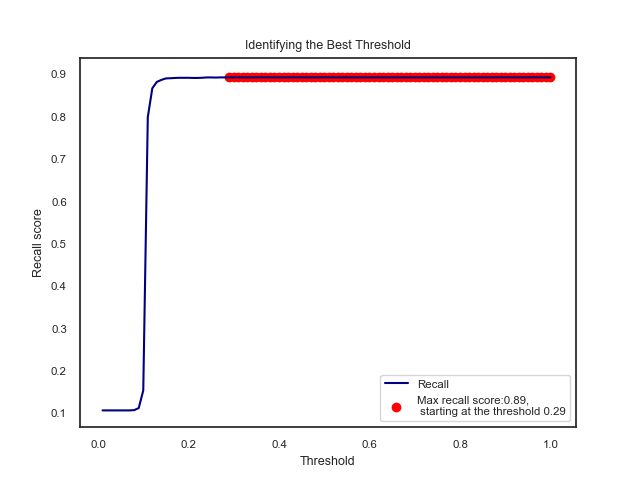

In [90]:
import seaborn
seaborn.set_style(style='white')
plt.figure()
plt.grid(False)

plt.plot(dff.index,dff.Recall,label="Recall",color="navy")
maX=[]
for i in y:
    maX.append(dff.Recall.max())
plt.scatter(y,maX,color="red",label="Max recall score:{},\n starting at the threshold {}".format(round(maX[0],2),round(y[0],2)))
plt.xlabel("Threshold");plt.ylabel('Recall score')
plt.title('Identifying the Best Threshold')
plt.legend()
plt.show()

# Improving Recall Rate

Two new features are created: Economic and Calendar. The features IPC and Confidence are combine to create the new feature Economic. IPC and Confidence are removed. The new feature Calendar is created multiplying the categorical features Day and Month.

In [612]:
Train3=train2.dropna()
var=['Age', 'Couple', 'Education', 'Job', 'Loan', 'Housing', 'Default',
       'Campaign', 'Day', 'Month','Calendar','EmployementRate','IPC','Confidence','Economic']
Train3["Economic"]=Train3.IPC*Train3.Confidence
Train3["Calendar"]=Train3.Day*Train3.Month
X=Train3.loc[:,var]

y=Train3["Deposit"]
X_Train, X_Test, y_Train, y_Test = train_test_split(X,y,random_state=0)

######## Test 1 ###############
Test1=test1.dropna()
Test1["Economic"]=Test1.IPC*Test1.Confidence
Test1["Calendar"]=Test1.Day*Test1.Month
X_Test1=test1.loc[:,var]
y_Test1=Test1.Deposit

######## Test 2 ###############
Test2=test2.dropna()
Test2["Economic"]=Test2.IPC*Test1.Confidence
Test2["Calendar"]=Test2.Day*Test1.Month
X_Test2=Test2.loc[:,var]
y_Test2=Test2.Deposit

In [358]:
def MyScaler3(x):
    import math
    '''This function scale with MinMax method only the features '''
    num=["Age",'Calendar','Economic']
    #num=["Age",'Economic']
    x_num=x[num]
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler().fit(x_num)  #compute minimum and maximum on the training data
    scaled = scaler.transform(x_num) # rescale X
        
    categoric=x[['Couple', 'Education', 'Job', 'Loan', 'Housing', 'Default',
       'Campaign', 'Day', 'Month']]
    df_num=pd.DataFrame(scaled);df_num.columns=num
    categoric.reset_index(inplace=True)
    df=pd.merge(df_num,categoric,left_index=True, right_index=True)
    return df

In [421]:
X_Train03=MyScaler3(X_Train); X_Test03=MyScaler3(X_Test)
X_Test13=MyScaler3(X_Test1); X_Test23=MyScaler3(X_Test2)

In [633]:
Scoring='recall_micro'
# 1) Logistic regression
logreg = LogisticRegression()
log_scores = cross_val_score(logreg, X_Train03,y_Train,cv=4,scoring=Scoring)

# 2) Linear support vector 
svm=LinearSVC(random_state=0,max_iter=100000) # should have random_state not to change estimates
svm_scores = cross_val_score(svm,  X_Train03, y_Train,cv=4,scoring=Scoring)

# 3) kernalized support vector
svc=SVC(kernel="linear",C=1,gamma=5,max_iter=100000)
svc_scores=cross_val_score(svc,  X_Train03, y_Train,cv=4,scoring=Scoring)

# 4) kernalized support vector with RBF
svc=SVC(kernel="rbf",C=1,gamma=5,max_iter=100000)
svc_rbf_scores=cross_val_score(svc,  X_Train03, y_Train,cv=4,scoring=Scoring)

# knn
knn = KNeighborsClassifier(n_neighbors=3)
knn_scores = cross_val_score(knn,  X_Train03, y_Train,cv=4,scoring=Scoring)

# Neural network (multilayer perceptron)
mpl=MLPClassifier(random_state=0,hidden_layer_sizes=[21])
mpl_scores=cross_val_score(mpl, X_Train03, y_Train,cv=4,scoring=Scoring)

# Decision tree
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree_scores=cross_val_score(tree, X_Train03, y_Train,cv=4,scoring=Scoring)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(n_estimators=5, random_state=2)
forest_scores=cross_val_score(forest, X_Train03, y_Train,cv=4,scoring=Scoring)

# Gradient
from sklearn.ensemble import GradientBoostingClassifier
grad = GradientBoostingClassifier(random_state=0)
grad_scores=cross_val_score(grad, X_Train03, y_Train,cv=4,scoring=Scoring)

["Logistic: {}".format(round(log_scores.mean(),3)),"SVM: {}".format(round(svm_scores.mean(),3))
                  ,"SVC, with linear kernel :{}".format(round(svc_scores.mean(),3)),"SVC with RBF:{}".format(round(svc_rbf_scores.mean(),3)),
         "MPL: {}".format(round(mpl_scores.mean(),3)),"KNN: {}".format(round(knn_scores.mean(),3)),"Tree: {}".format(round(tree_scores.mean(),3)),
"Forest: {}".format(round(forest_scores.mean(),3)),"Gradient: {}".format(round(grad_scores.mean(),3))]


['Logistic: 0.89',
 'SVM: 0.89',
 'SVC, with linear kernel :0.543',
 'SVC with RBF:0.89',
 'MPL: 0.857',
 'KNN: 0.868',
 'Tree: 0.885',
 'Forest: 0.883',
 'Gradient: 0.886']

These results are similar to the previous. To improve the recall score, an ensemble method is used bellow, the gradient boosting classifier. I look simultaneously for the learning rate, the maximum features and the maximum depth that return the best recall score.

In [393]:
rate=[0.05,0.5,0.65]
y=Seq(1,10,1)
In=[];Jn =[] ;TrainScore=[];TestScore=[];Test1Score=[];Rate=[]
for r in rate:
    for i in y:
        for j in y:
            gbc=GradientBoostingClassifier(learning_rate=r,max_features=i, max_depth=j, n_estimators=999,random_state=0)
            gbc.fit(X_train0,y_train)
            In.append(i)
            Jn.append(j)
            Rate.append(r)
            TrainScore.append(gbc.score(X_train0,y_train))
            TestScore.append(gbc.score(X_test0,y_test))
            Test1Score.append(gbc.score(X_test1,y_test1))
df=pd.DataFrame({'Idx_i':In,'Idx_j':Jn,'Rate':Rate,'TrainSc':TrainScore,'TestSc':TestScore,'TS1':Test1Score})
#pd.DataFrame(TrainScore,TestScore,Test1Score)


In [635]:
xi=[];xj=[];ra=[];tr=[];ts=[];ts1=[]
for i in df.index:
    if df.TrainSc[i]<=df.TestSc[i] and df.TestSc[i]>=0.89:
        xi.append(df.Idx_i[i]);xj.append(df.Idx_j[i]);ra.append(df.Rate[i])
        tr.append(df.TrainSc[i]);ts.append(df.TestSc[i]);ts1.append(df.TS1[i])
dk=pd.DataFrame({'MaxFeature':xi,'MaxDepth':xj,'Rate':ra,'TrainSc':tr,'TestSc':ts,'TS1':ts1})

In [636]:
dk

,MaxFeature,MaxDepth,Rate,TrainSc,TestSc,TS1
0,1,1,0.05,0.892030,0.897855,0.890835
1,2,1,0.05,0.894074,0.896834,0.890581
2,3,1,0.05,0.894414,0.895812,0.890327
3,4,1,0.05,0.894755,0.899898,0.890327
4,8,1,0.05,0.896458,0.896834,0.890074
5,9,1,0.05,0.896458,0.896834,0.890074
6,10,1,0.05,0.895095,0.898876,0.890074


In [637]:
for i in dk.index:
    if dk.TestSc[i]==max(dk.TestSc):
        print(dk.loc[i:i,:])

   MaxFeature  MaxDepth  Rate   TrainSc    TestSc       TS1
3           4         1  0.05  0.894755  0.899898  0.890327


The results show that the best recall is obtained when the maximum features is 4, the learning rate is 0.05 and the maximum depth is 1. However, the recall score is similar to the previous, lower than the goal of the project which is 0.95.

When iterating the threshold, the best recall score we can obtain is 0.905, which is bellow the goal of the project. Thus, another strategy should be used to improve the recall score.

In [638]:
thresholds=Seq(0.05,0.8,0.005)
rec=[]
for t in thresholds:
    gbc=GradientBoostingClassifier(learning_rate=0.05,max_features=4, max_depth=1, n_estimators=100,random_state=0)
    gbc.fit(X_Train03,y_Train)
    y_pred=np.where(gbc.predict_proba(X_Test03)[:,1] > t, 1, 0)
    rec.append(recall_score(y_Test,y_pred,average='micro'))
max(rec)

0.9050051072522982

### Combining two models

In this subsection the mean of the estimated probabilities from two models is calculated, and several values of the threshold are iterated to find the highest value of the recall score obtained.

In [641]:
Mysvc=SVC(kernel="rbf",C=1,gamma=0.01,max_iter=100000,random_state=0,probability=True).fit(X_Train03,y_Train)
logreg1 = LogisticRegression().fit(X_Train03,y_Train)
mpl1=MLPClassifier(random_state=0,hidden_layer_sizes=[21]).fit(X_Train03,y_Train)

In [565]:
pred1=Mysvc.predict_proba(X_Test03)[:,1]
pred2=logreg1.predict_proba(X_Test03)[:,1]
pred3=mpl1.predict_proba(X_Test03)[:,1]

In [564]:
mpl1=MLPClassifier(random_state=0,hidden_layer_sizes=[21]).fit(X_Train03,y_Train)

In [579]:
id=list(range(len(pred2)))
m=np.array([])
for i in id:
    m=np.append(m,np.mean([pred1[i],pred2[i]]))
Rec=[]
for i in Seq(0.05,0.9,0.05):
    Y=np.where(m > i, 1, 0)
    Rec.append(recall_score(y_Test,Y))
Rec    

[1.0,
 0.8571428571428571,
 0.11224489795918367,
 0.01020408163265306,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [581]:
id=list(range(len(pred2)))
m=np.array([])
for i in id:
    m=np.append(m,np.mean([pred1[i],pred3[i]]))
Rec=[]
for i in Seq(0.05,0.9,0.05):
    Y=np.where(m > i, 1, 0)
    Rec.append(recall_score(y_Test,Y))
Rec     

[1.0,
 0.32653061224489793,
 0.04081632653061224,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [582]:
id=list(range(len(pred2)))
m=np.array([])
for i in id:
    m=np.append(m,np.mean([pred2[i],pred3[i]]))
Rec=[]
for i in Seq(0.05,0.9,0.05):
    Y=np.where(m > i, 1, 0)
    Rec.append(recall_score(y_Test,Y))
Rec     

[0.9795918367346939,
 0.46938775510204084,
 0.16326530612244897,
 0.061224489795918366,
 0.02040816326530612,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

The best recall score is obtained when combining the probabilities estimated by the logistic regression model and the mpl classifier model, with a threshold of 0.05. 

In [631]:
def combMLPred(Xtest,ytest):
    def MyScaler3(x):
        import math
        '''This function scale with MinMax method only the features '''
        num=["Age",'Calendar','Economic']
        #num=["Age",'Economic']
        x_num=x[num]
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler().fit(x_num)  #compute minimum and maximum on the training data
        scaled = scaler.transform(x_num) # rescale X

        categoric=x[['Couple', 'Education', 'Job', 'Loan', 'Housing', 'Default',
           'Campaign', 'Day', 'Month']]
        df_num=pd.DataFrame(scaled);df_num.columns=num
        categoric.reset_index(inplace=True)
        df=pd.merge(df_num,categoric,left_index=True, right_index=True)
        return df
    #############################
    X_Train03=MyScaler3(X_Train); Xtest=MyScaler3(Xtest)
    
    logreg1 = LogisticRegression().fit(X_Train03,y_Train)
    mpl1=MLPClassifier(random_state=0,hidden_layer_sizes=[21]).fit(X_Train03,y_Train)
    pred2=logreg1.predict_proba(Xtest)[:,1]
    pred3=mpl1.predict_proba(Xtest)[:,1]
    id=list(range(len(pred2)))
    m=np.array([])
    for i in id:
        m=np.append(m,np.mean([pred2[i],pred3[i]]))
    Y=np.where(m > 0.05, 1, 0)
    Rec=recall_score(ytest,Y)
    return Rec

In [632]:
combMLPred(Xtest=X_Test,ytest=y_Test)

0.9795918367346939